In [1]:
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import fisher_exact

import numpy as np

import pandas as pd

from adjustText import adjust_text

sc.set_figure_params(dpi=120)
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [2]:
## Colormaps
response_palette = {'R':'teal','NR':'orangered'}
product_palette = {'Kymriah':'blue','Yescarta':'orange'}

In [3]:
limma_dir = '../data/limma_results'

In [4]:
def volcano2(df,thresh=.25,ax=None,label=False,min_size=1,max_size=50,palette=None):
    gene_show = df[df['adj.P.Val']<thresh].sort_values('logFC').index
    
    df['sig']='nonsignificant'
    df.loc[(df['adj.P.Val']<thresh)&(df['logFC']>0),'sig']='up'
    df.loc[(df['adj.P.Val']<thresh)&(df['logFC']<0),'sig']='down'
    
    if palette is None:
        palette = {'nonsignificant':'gray','up':'blue','down':'red'}
    
    
    df['nlogp'] = -1*np.log10(df['P.Value'])
    df['size'] = df['nlogp']*df['logFC'].abs()
    df['size'] = df['size']/df['size'].max()
    
    if ax is None:
        f,ax = plt.subplots(1)
    g=sns.scatterplot(x="logFC",y="nlogp",data=df,hue='sig',size="size",sizes=(min_size,max_size),
                      ax=ax,palette=palette,legend=False,rasterized=True)
    
    
    if label:
        texts = [ax.text(row['logFC'],row['nlogp'],gene) for 
                 gene,row in df[df['adj.P.Val']<thresh].iterrows()]
        adjust_text(texts)
    ax.grid(False)

## Figure 2b

In [5]:
def CAR_specific_comp(timepoint,ax=None):
    
    comparison_colors = {'non-significant':'grey','Tisa-only':'blue','Axi-only':'orange','Both':'red'}
    
    dfK = pd.read_csv(f'{limma_dir}/Kymriah.{timepoint}.csv',index_col = 0)
    dfY = pd.read_csv(f'{limma_dir}/Yescarta.{timepoint}.csv',index_col = 0)

    if ax is None:
        f,ax=plt.subplots(1,figsize=(8,8))


    df = dfK.join(dfY,lsuffix='_K',rsuffix='_Y')
    df = df[~df.index.str.match('Kymriah|Yescarta')]

    df = df[df['AveExpr_K']>.5]

    # Just look for CAR-specific
    df.loc[df['logFC_K']<0,'adj.P.Val_K'] = 1
    df.loc[df['logFC_Y']<0,'adj.P.Val_Y'] = 1
    df.loc[df['logFC_K']<0,'P.Value_K'] = 1
    df.loc[df['logFC_Y']<0,'P.Value_Y'] = 1

    df['nlogp_K'] = -1*np.log10(df['P.Value_K'])
    df['nlogp_Y'] = -1*np.log10(df['P.Value_Y'])

    df['type']='non-significant'
    tisa_idx = (df['adj.P.Val_K']<.1)
    axi_idx = (df['adj.P.Val_Y']<.1)
    df.loc[tisa_idx,'type'] = 'Tisa-only'
    df.loc[axi_idx,'type'] = 'Axi-only'
    df.loc[tisa_idx&axi_idx,'type'] = 'Both'

    df['logFC_K'] = np.maximum(0,df['logFC_K'])
    df['logFC_Y'] = np.maximum(0,df['logFC_Y'])


    sns.scatterplot(df['nlogp_K'],df['nlogp_Y'],hue=df['type'],palette=comparison_colors,s=10,ax=ax)

    ax.legend(bbox_to_anchor=(1,1))


    tisa_show= df[(df['adj.P.Val_K']<.1)&(df['adj.P.Val_Y']>.1)].sort_values('adj.P.Val_K').head(n=5).index
    axi_show= df[(df['adj.P.Val_Y']<.1)&(df['adj.P.Val_K']>.1)].sort_values('adj.P.Val_Y').head(n=5).index

    df['p_max'] = df['adj.P.Val_K']*df['adj.P.Val_Y']


    both_show = df.sort_values('p_max').head(n=10).index


    gene_show = np.union1d(np.union1d(tisa_show,axi_show),both_show)


    ax.set_xlabel('-log10(p) Tisa-cel')
    ax.set_ylabel('-log10(p) Axi-cel')

    texts = [ax.text(row['nlogp_K'],row['nlogp_Y'],gene,style='italic') 
                     for gene,row in df.loc[gene_show].iterrows()]

    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5),ax=ax)
    
    ax.grid(False)


/home/njharlen/anaconda3/envs/scanpy1_8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/njharlen/anaconda3/envs/scanpy1_8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


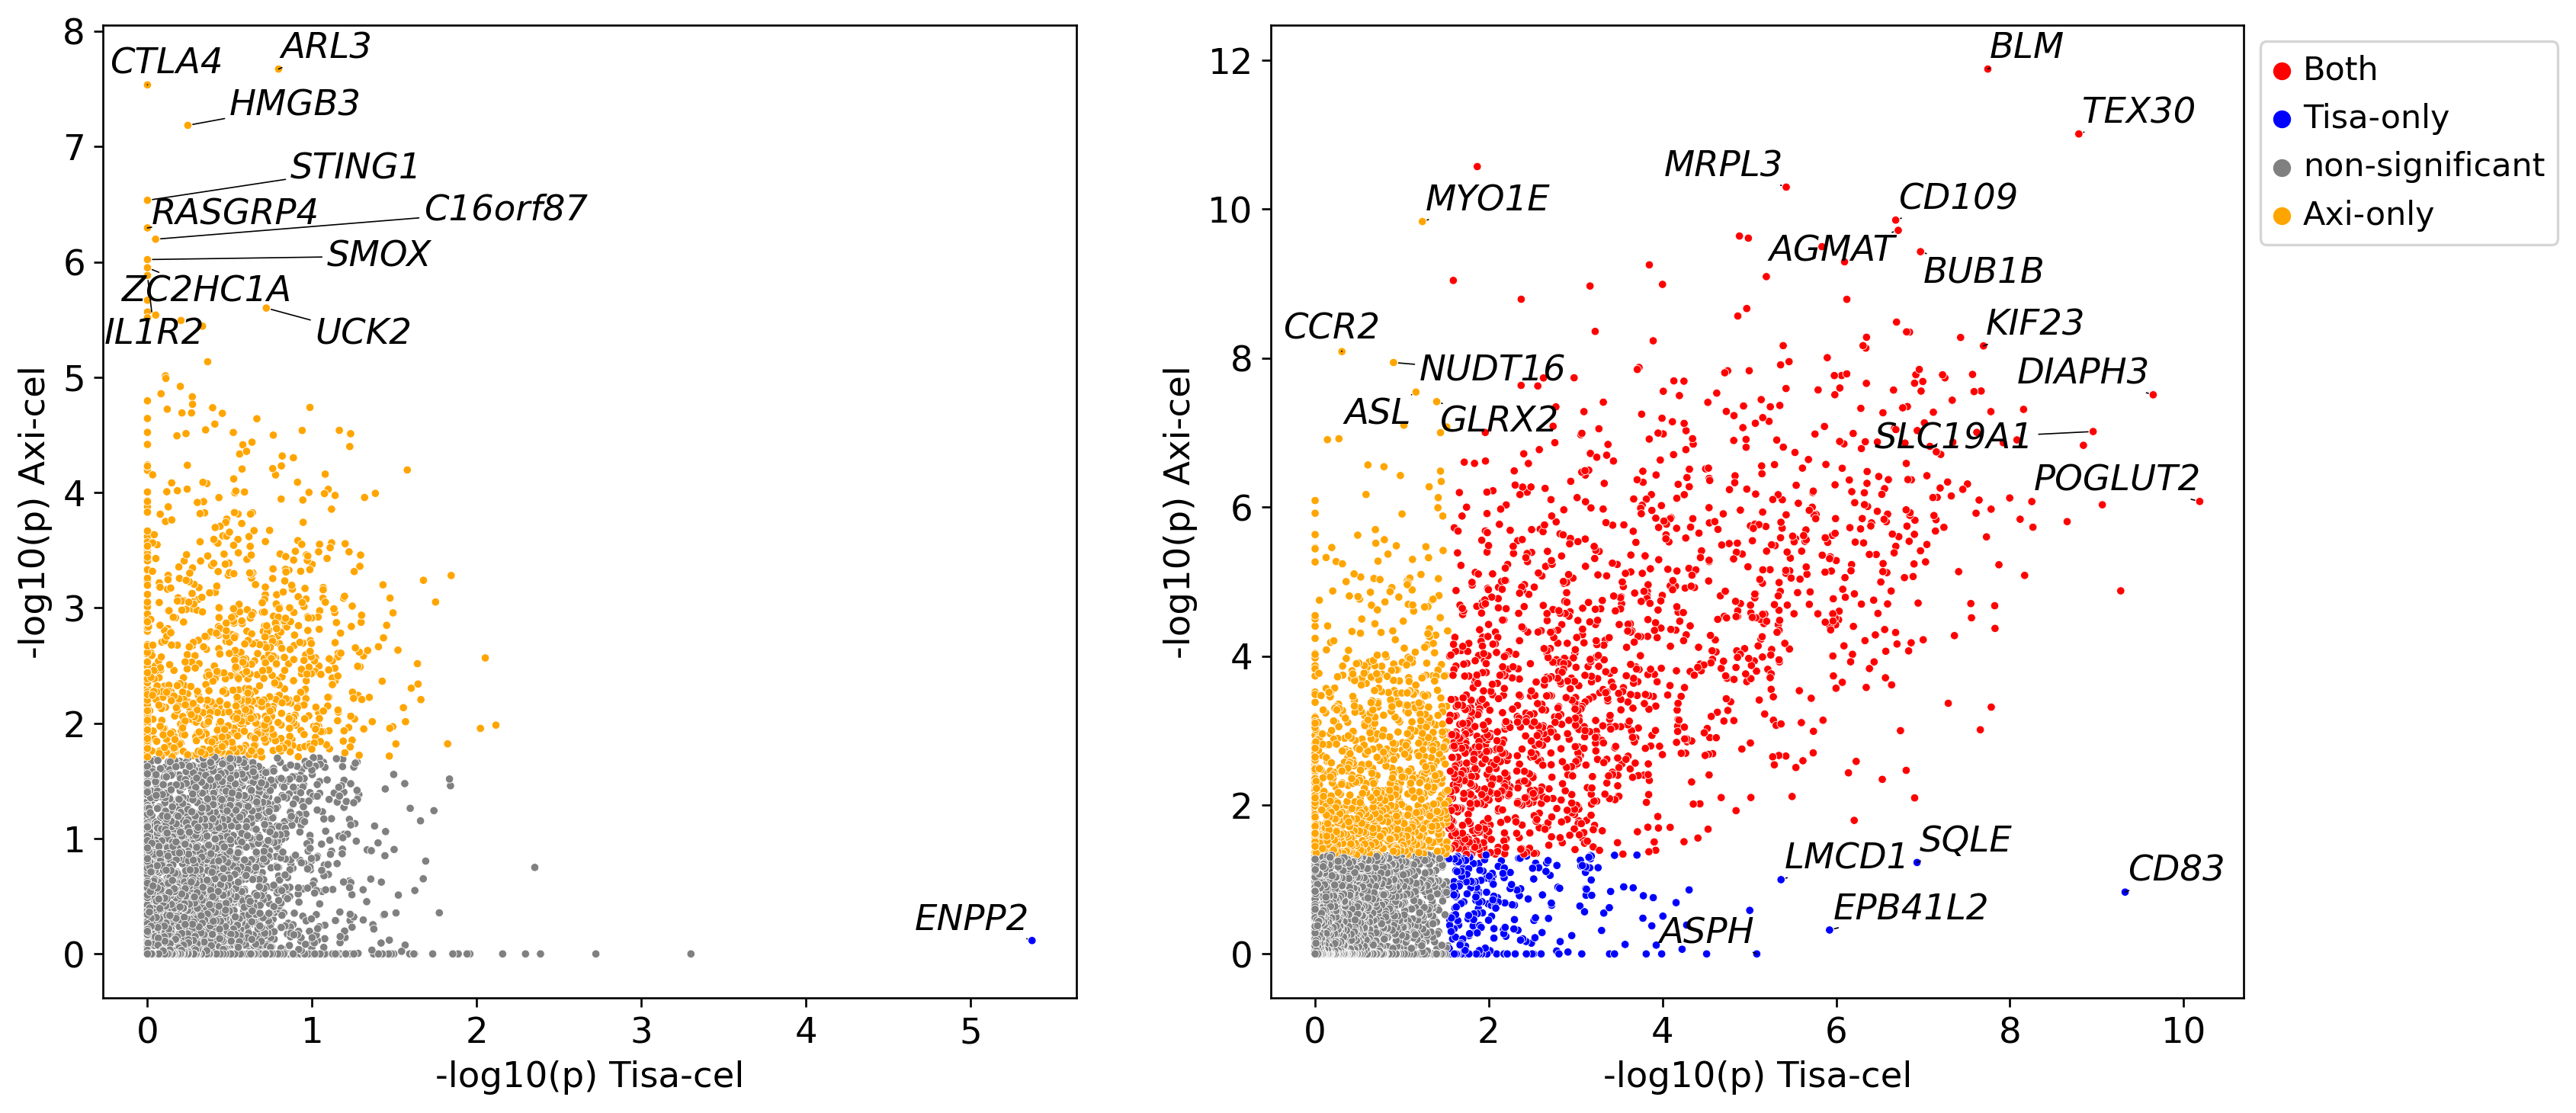

In [6]:
f,ax=plt.subplots(1,2,figsize=(15,7))

CAR_specific_comp('Infusion',ax=ax[0])
ax[0].legend().remove()
CAR_specific_comp('D7',ax=ax[1])

## Figure 2c

In [7]:
def timecourse_heatmap(adata,genes,subtype=None,min_cells=50,figsize=None,row_cluster=True,cmap=None,**kwargs):
    
    idx = adata.obs['type'].isin(['Infusion','D7-CAR-T'])
    
    if not subtype is None:
        idx = idx&(adata.obs['subtype']==subtype)

    # Restrict to samples that have both types >=50 cells
    samp_counts = adata.obs[idx].value_counts(['barcode','type'])
    pat_counts = samp_counts[samp_counts>=min_cells].reset_index().value_counts('barcode')
    
    pat_use = pat_counts[pat_counts==2].index.values

    idx = idx&adata.obs['barcode'].isin(pat_use)

    X = pd.DataFrame(index = adata.obs[idx].astype({'type':str,'barcode':str}).groupby(['barcode','type']).count().index,
                columns=adata.raw.var.index)
    for ind,g in adata.obs[idx].astype({'type':str,'barcode':str}).groupby(['barcode','type']):
        X.loc[ind,:] = adata.raw[g.index,:].X.mean(axis=0)
    X=X.astype(float)
    
    X = X.reset_index()
    X['type'] = pd.Categorical(X['type'],categories=['Infusion','D7-CAR-T'])
    X = X.sort_values(['barcode','type'])
    X = X.set_index(['barcode','type'])
    
    if figsize is None:
        figsize=(20,10)
    g = sns.clustermap(X[genes].T,col_cluster=False,
                       row_cluster=row_cluster,z_score=0,figsize=figsize,cmap=cmap,**kwargs)

    for i in range(0,int(X.shape[0]/2)):
        g.ax_heatmap.axvline(i*2,color='w',linewidth=10)
    return(g)

In [8]:
adata = sc.read("/home/njharlen/git/Haradhvala_et_al_2022/data/CART_fulldataset_clustered.h5ad")

In [9]:
adata = adata[~adata.obs['subtype'].isna()]

adata.obs['CAR'] = (((adata.obs['product']=='Yescarta')&(np.array(adata.raw[:,'Yescarta'].X.todense()).reshape(-1)>0)) | \
((adata.obs['product']=='Kymriah')&(np.array(adata.raw[:,'Kymriah'].X.todense()).reshape(-1)>0))) & \
(adata.obs['timepoint']!="Baseline")

adata.obs['type']=adata.obs['timepoint'].astype(str)
adata.obs.loc[adata.obs['CAR']&adata.obs['timepoint'].str.match('D7'),'type'] = 'D7-CAR-T'
adata.obs.loc[~adata.obs['CAR']&(adata.obs['timepoint']=="D7-CART"),'type'] = 'Unknown'


/tmp/ipykernel_5174/954290634.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['CAR'] = (((adata.obs['product']=='Yescarta')&(np.array(adata.raw[:,'Yescarta'].X.todense()).reshape(-1)>0)) | \


In [10]:
genes = pd.Series(['BATF3','CD74','DDIT4','ARID5A','HLA-DRA','G0S2',
         'JUNB','HLA-DPA1','ELL2','MIR155HG','HLA-DPB1','HLA-DRB1','ADCY1',
         'TNFRSF8','BIRC3','ENPP2','CXCL10','HMSD','SH3BP5','PRKCDBP','IL4I1','TNIP2','ANK3'])
genes = genes[genes.isin(adata.raw.var.index)]

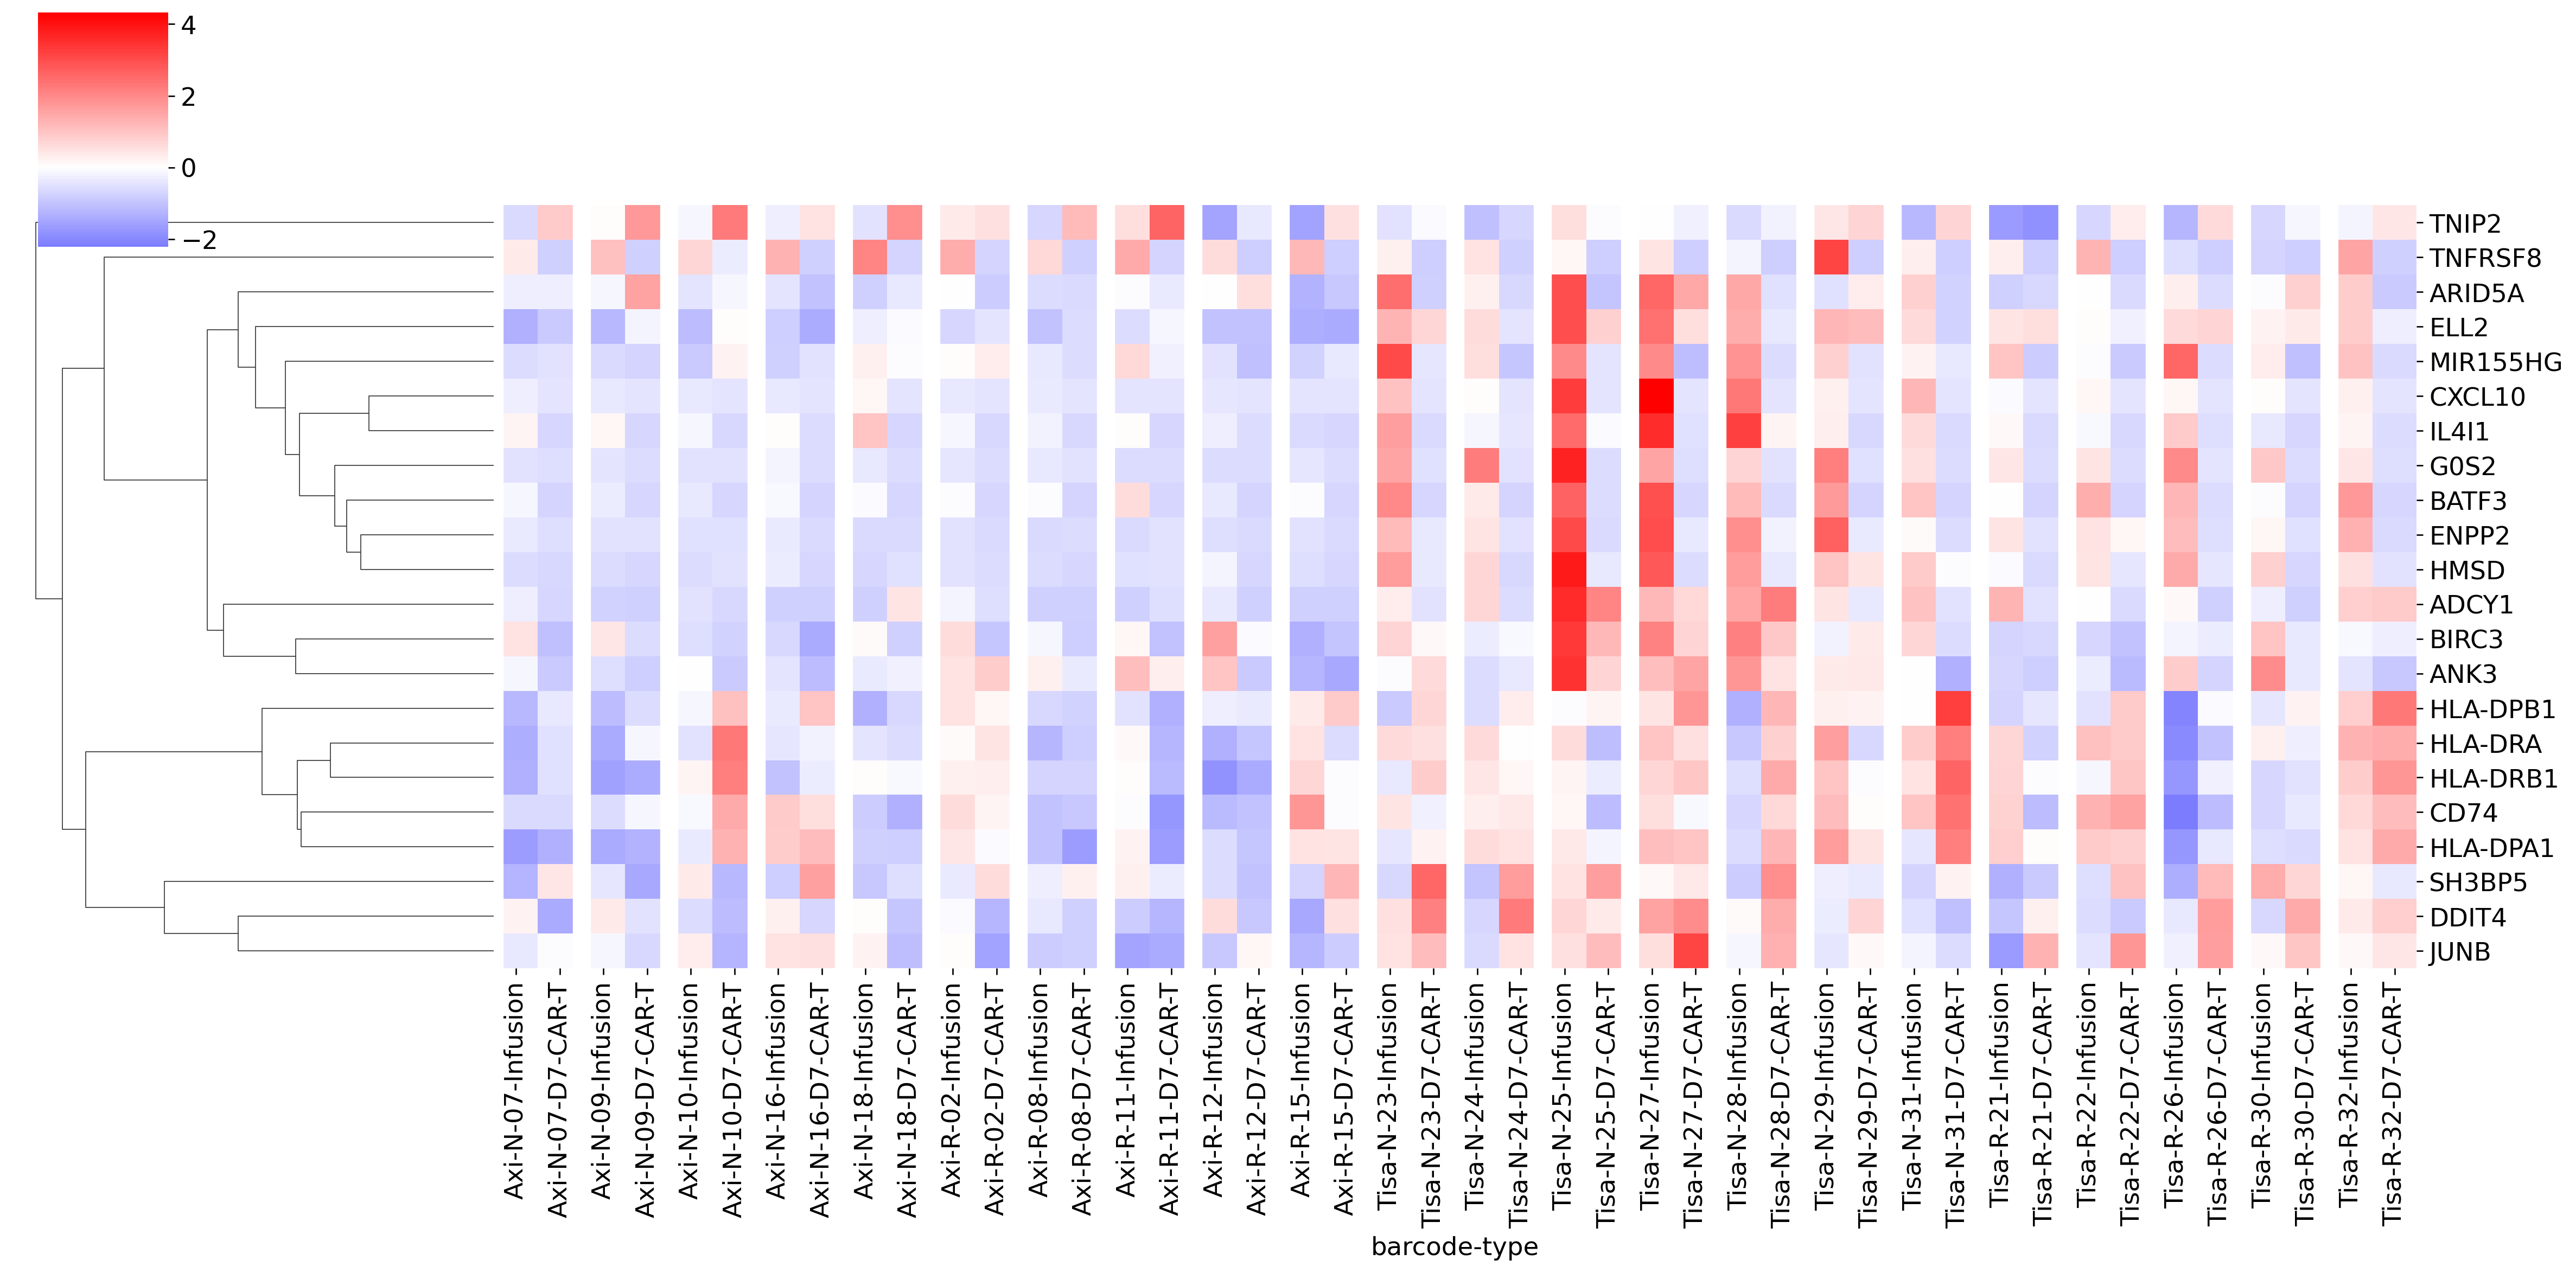

In [11]:
timecourse_heatmap(adata,genes,cmap="bwr",center=0,figsize=(20,10))

## Figure 2d

In [12]:
dfK = pd.read_csv(limma_dir + '/Kymriah_IP_vs_D7.CD8.csv',
                 index_col = 0)
dfY = pd.read_csv(limma_dir + '/Yescarta_IP_vs_D7.CD8.csv',
                 index_col = 0)

df = dfK.join(dfY,lsuffix="_K",rsuffix="_Y")

for prod in ['K','Y']:
    df[prod] = -1*np.log10(df[f'adj.P.Val_{prod}'])
    df.loc[df[f'logFC_{prod}']<0,prod] = -1*df.loc[df[f'logFC_{prod}']<0,prod]

/home/njharlen/anaconda3/envs/scanpy1_8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/njharlen/anaconda3/envs/scanpy1_8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


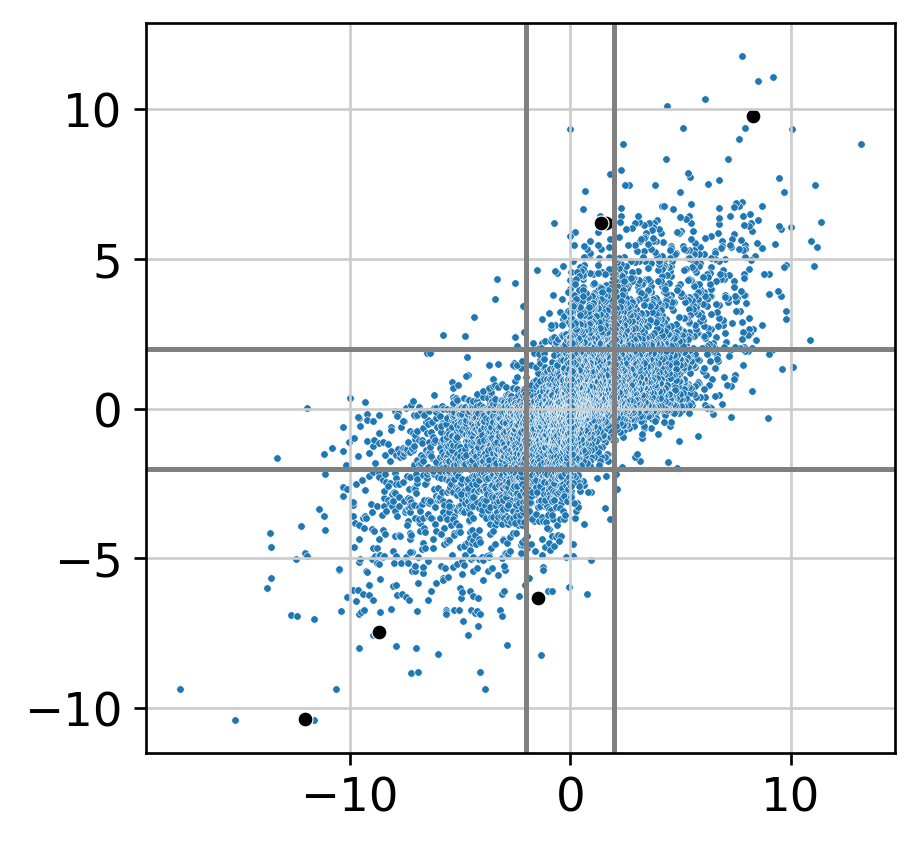

In [13]:
genes_of_interest=['PDCD1','SLAMF6','SOS1','ZBP1','IRF4','CISH']
gidx = df.index.isin(genes_of_interest)
    
sns.scatterplot("K","Y",data=df[~gidx],s=5)
sns.scatterplot("K","Y",data=df[gidx],s=20,color='black')



plt.xlabel('')
plt.ylabel('')

#plt.xlabel('Up in Kymriah IP -> Up in Kymriah D7')
#plt.ylabel('Up in Yescarta IP -> Up in Yescarta D7')

lc = 'grey'
plt.axhline(2,color=lc)
plt.axvline(2,color=lc)
plt.axhline(-2,color=lc)
plt.axvline(-2,color=lc)

## Figure 2e

In [14]:
E = pd.read_csv('../data/ALL_T_cells_pseudobulk.csv')

genes = E.columns[7:]
E[genes] = np.log10(1+(1e6*E[genes].T/E[genes].T.sum()).T)

E['generic'] = E['product'].map({'Kymriah':'Tisa-cel','Yescarta':'Axi-cel'})

/tmp/ipykernel_5174/4086761226.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E['generic'] = E['product'].map({'Kymriah':'Tisa-cel','Yescarta':'Axi-cel'})


In [15]:
def single_gene_plot(E,gene,ax=None,abbreviate=False,ha='left',va='bottom'):
    idx = (E['subtype']=='CD8 T')&(E['type'].isin(['Infusion','D7-CAR-T']))

    palette = {'Tisa-cel':'blue','Axi-cel':'orange'}

    if ax is None:
        f,ax=plt.subplots(1)

    sns.violinplot(x="type",y=gene,hue="generic",split=True,data=E[idx],ax=ax,legend=False,
              palette=palette)
    ylim = ax.get_ylim()
    xlim = ax.get_xlim()

    sns.lineplot(x="type",y=gene,data=E[idx],hue='generic',
             marker="o",units='barcode',estimator=None,
                 legend=False,ax=ax,palette=palette)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.grid(False)

    ax.legend(bbox_to_anchor=(1,1))
    ax.set_ylabel(f'{gene} (log10 TPM)')
    
    # Add stats
    colors = {'K':'blue','Y':'orange'}
    posoffsets = {'K':.02,'Y':.12}
    negoffsets = {'K':-.12,'Y':-.02}

    if ha=='left':
        xlabpos = xlim[0]+.02*(xlim[1]-xlim[0])
    else:
        xlabpos = xlim[1]-.02*(xlim[1]-xlim[0])
            
        
    
    for prod in ['K','Y']:
        q = df.loc[gene,f'adj.P.Val_{prod}']
        lfc = df.loc[gene,f'logFC_{prod}']
        fc = 2.0**df.loc[gene,f'logFC_{prod}']
        pct_change = 100*(2.0**df.loc[gene,f'logFC_{prod}']-1)
        
        if abbreviate:
            label = f"{lfc:.2f} ({sci_notation(q)})"
        else:
            label = f"FC={lfc:.2f} (q={sci_notation(q)})"
        #label = f"{pct_change:.0f}% (q={sci_notation(q)})"
            
        if va=='bottom':
            ylabpos=ylim[0] + posoffsets[prod]*(ylim[1]-ylim[0])
        else:
            ylabpos=ylim[1] + negoffsets[prod]*(ylim[1]-ylim[0])

        ax.text(xlabpos,ylabpos,label,
                                                 color=colors[prod],fontsize=10,ha=ha,va=va)
    
def sci_notation(number, sig_fig=1):
    ret_string = "{0:.{1:d}e}".format(number, sig_fig)
    a, b = ret_string.split("e")
    # remove leading "+" and strip leading zeros
    b = int(b)
    return "$" + a + " \\times 10^{" + str(b) + "}$"    
    

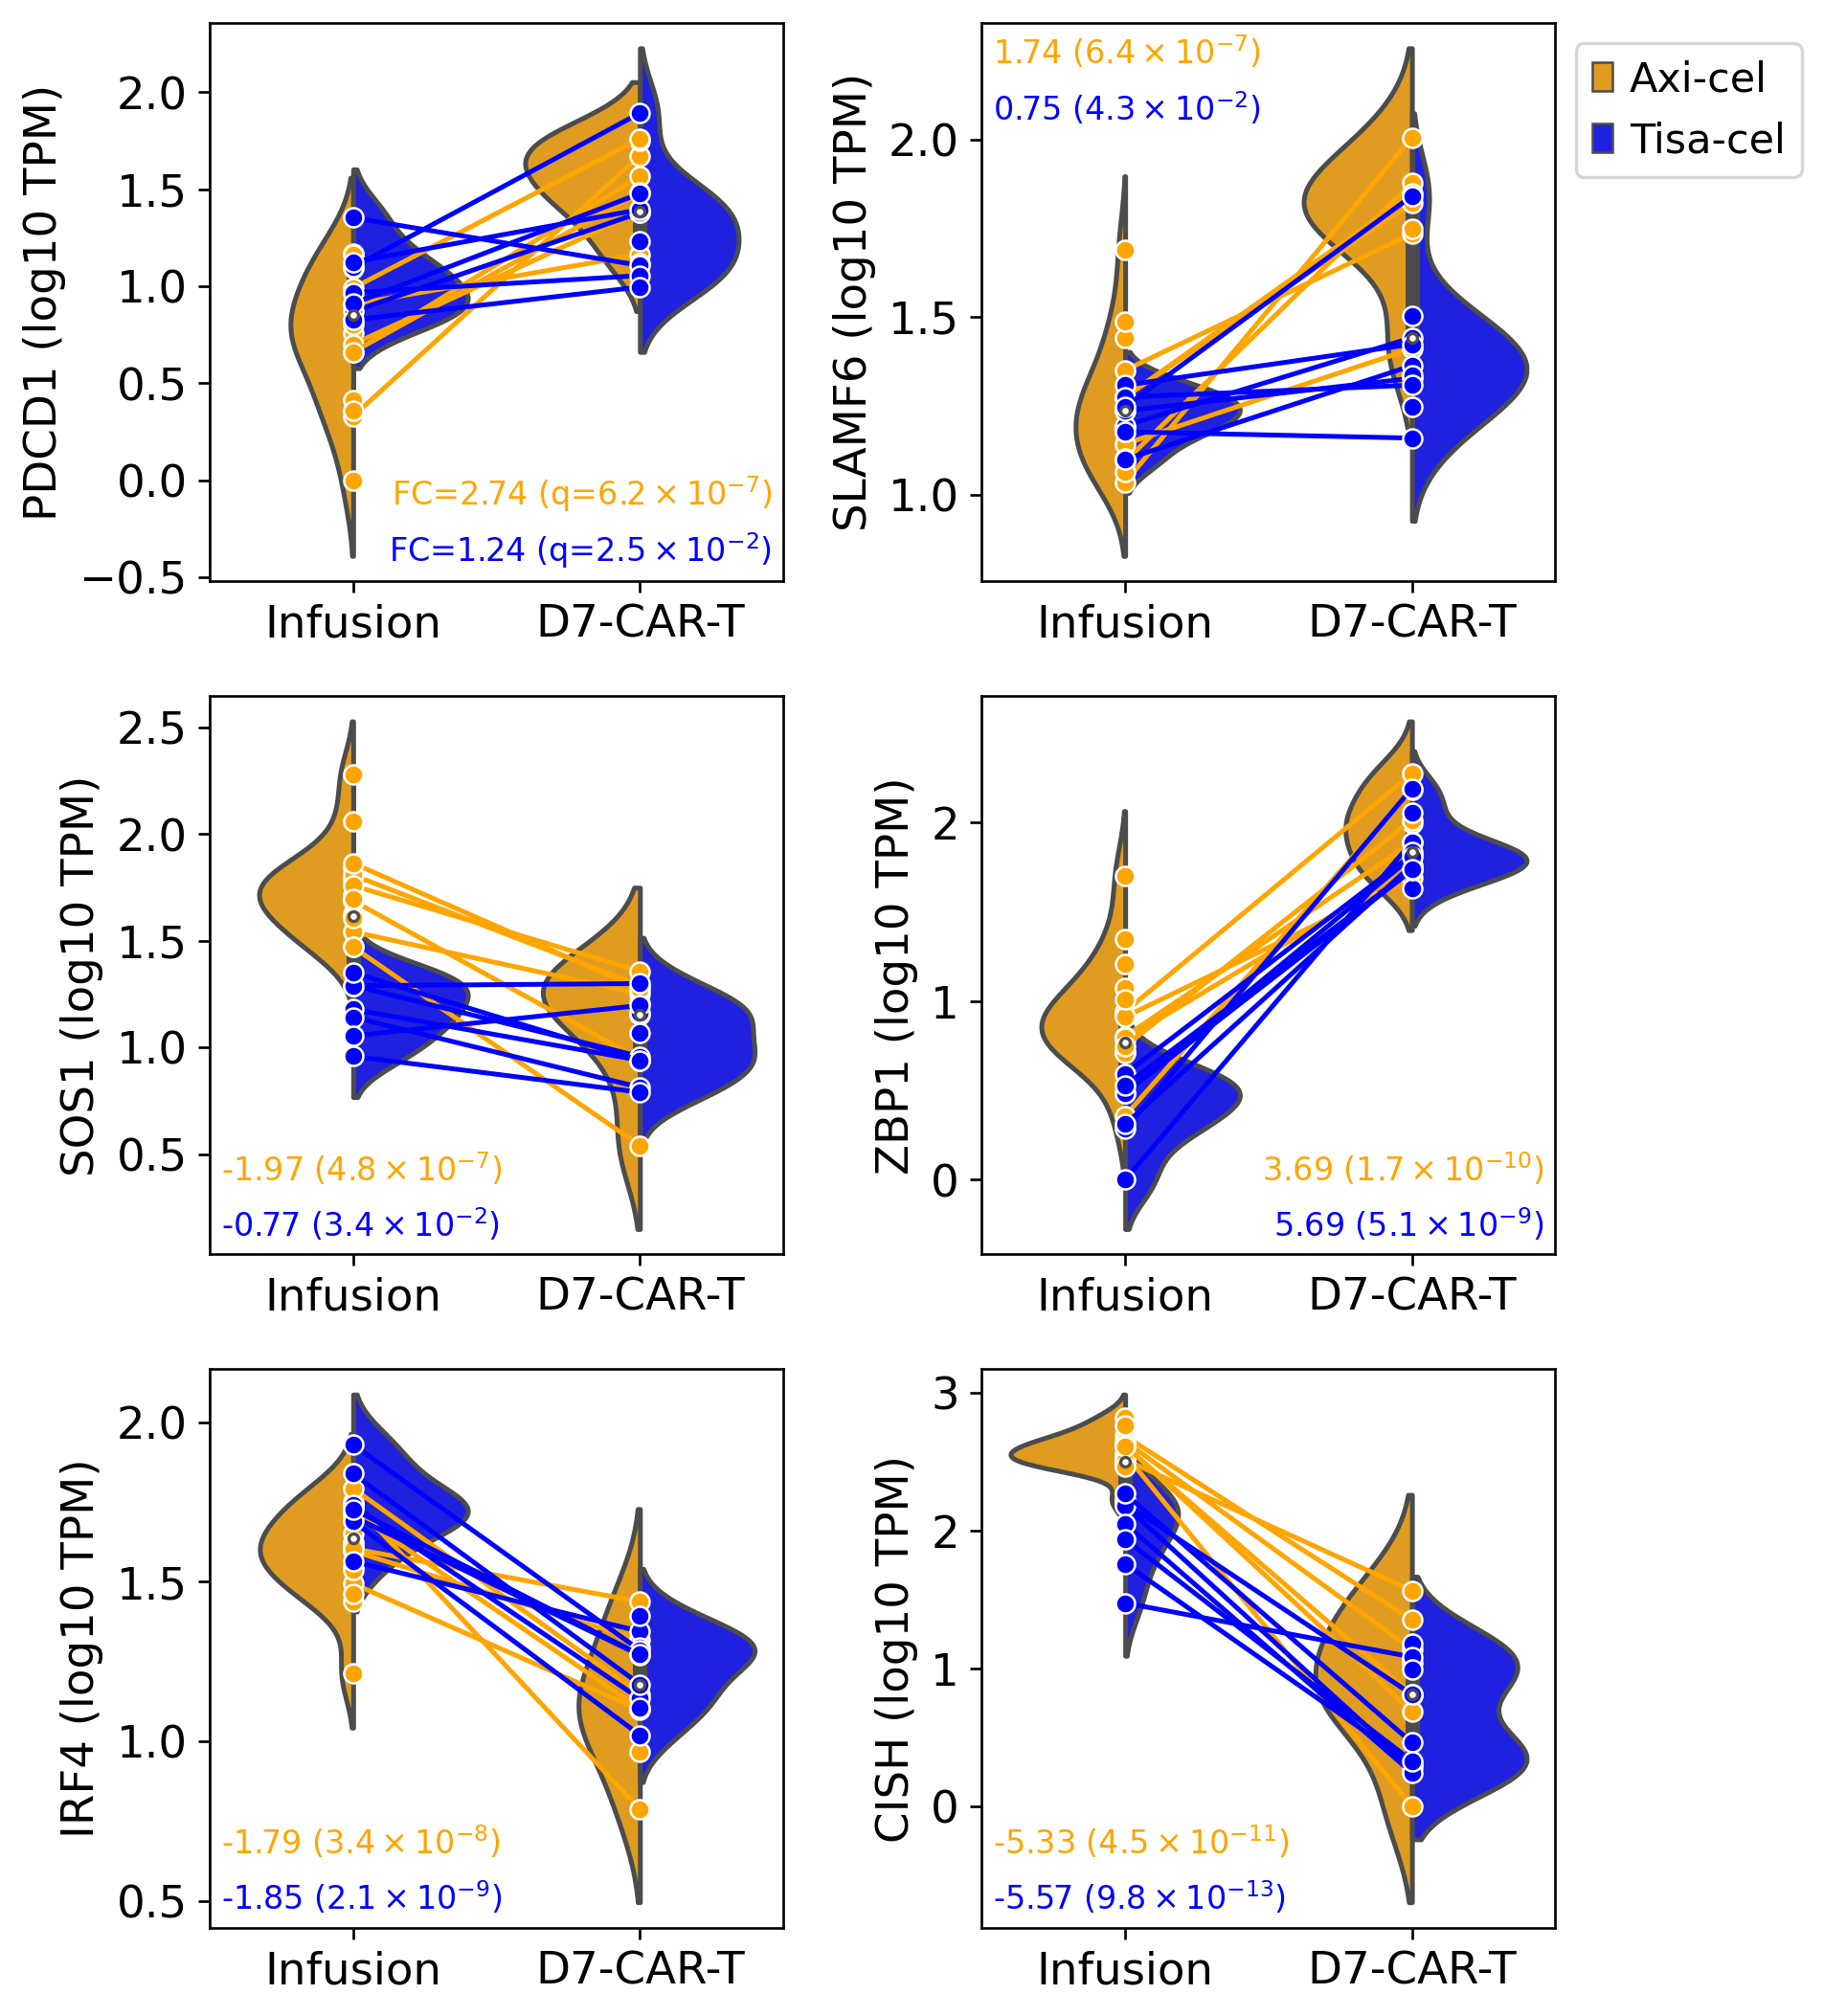

In [16]:
f,ax = plt.subplots(3,2,figsize=(8,9))
ax = ax.reshape(-1)
i=0
for gene in genes_of_interest:
    ha = 'left' if i in [1,2,4,5] else 'right'
    va = 'bottom' if i in [0,2,3,4,5] else 'top'

    single_gene_plot(E,gene,ax=ax[i],abbreviate=i>0,ha=ha,va=va)
    
    if i!=1:
        ax[i].legend().remove()
    ax[i].set_xlabel('')
    i+=1
plt.tight_layout()